In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import WindowDataset
import CustomModels
import CustomMetrics
import CustomWindowGenerator

%load_ext autoreload
%autoreload 2

# DATASET

## Load Dataset

In [2]:
data_horaria_estandarizada_path = os.path.join('..','..','dataset','Series','Sabanas','Estandarizada','Sabana_Datos_Horaria_Estandarizada.xlsx')
data_horaria_estandarizada = pd.read_excel(data_horaria_estandarizada_path)
data_horaria_estandarizada = data_horaria_estandarizada.set_index('Fecha')

In [3]:
precio_bolsa_path = os.path.join('..','..','dataset','Series','Sabanas','Estandarizada','Sabana_Datos_Precio_Bolsa_Estandarizada.xlsx')
precio_bolsa = pd.read_excel(precio_bolsa_path)
precio_bolsa = precio_bolsa.set_index('Fecha')

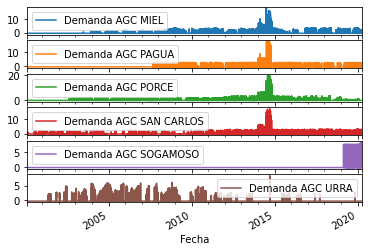

In [4]:
plot_cols = data_horaria_estandarizada.columns[-6:]
plot_features = data_horaria_estandarizada[plot_cols]
_ = plot_features.plot(subplots=True)

In [5]:
full_df = pd.concat([data_horaria_estandarizada,precio_bolsa],axis=1)
full_df.shape,data_horaria_estandarizada.shape,precio_bolsa.shape

((176760, 85), (176760, 84), (176760, 1))

In [6]:
train_df = full_df[(full_df.index >= '2000-01-01') & (full_df.index < '2019-01-01')]
val_df = full_df[(full_df.index >= '2019-01-01') & (full_df.index < '2020-01-01')]
test_df = full_df[full_df.index >= '2019-12-31']

train_df.shape,val_df.shape,test_df.shape

((165816, 85), (8760, 85), (2208, 85))

## Build Window

In [7]:
inputs_columns = ['Generacion ALBAN', 'Generacion BETANIA', 'Generacion CHIVOR',
          'Generacion EL QUIMBO', 'Generacion GUATAPE', 'Generacion GUATRON',
          'Generacion GUAVIO', 'Generacion LA TASAJERA', 'Generacion MIEL',
          'Generacion PAGUA', 'Generacion PLAYAS', 'Generacion PORCE',
          'Generacion SAN CARLOS', 'Generacion SOGAMOSO', 'Generacion URRA','$kWh']
#output_columns = inputs_columns

#inputs_columns = ['$kWh']
output_columns = ['$kWh']

In [8]:
window_train = CustomWindowGenerator.MyWindowDatasetGenerator(data=train_df, times=24, shift=1,
                                                              input_signals=inputs_columns, output_signals=output_columns)

train_generator = window_train.make_dataset(train_df,batch_size=16,suffle=True)

In [9]:
window_val = CustomWindowGenerator.MyWindowDatasetGenerator(data=val_df, times=24, shift=1,
                                                            input_signals=inputs_columns, output_signals=output_columns)

val_generator = window_val.make_dataset(val_df,batch_size=16,suffle=True)

In [10]:
window_test = CustomWindowGenerator.MyWindowDatasetGenerator(data=test_df, times=24, shift=24,
                                                             input_signals=inputs_columns, output_signals=output_columns)

test_generator = window_test.make_dataset(test_df,batch_size=16,suffle=False,sequence_stride=24)

# MODELS

## Instantiate Models

In [11]:
custom_rnn  = CustomModels.CustomRNN(rnn_units=90,output_units=len(output_columns))
custom_lstm = CustomModels.CustomLSTM(lstm_units=83,output_units=len(output_columns))
custom_gru  = CustomModels.CustomGRU(gru_units=90,output_units=len(output_columns))
custom_cnn  = CustomModels.CustomCNN(dropout_rate=0.31,output_units=len(output_columns))

## Instantiate metrics dicts

In [12]:
val_performance = dict()
performance = dict()

## Compile & Fit Method

In [13]:
def compile_and_fit(model, window_train, window_val, epochs, steps_per_epoch, val_steps,patience):
    """
    Este método se encarga de definir las funciones Callback, compilar y además realizar entrenar
    el modelo. Entre las funciones Callback que se definen aquí están: Logs de TensorBoard, Redu-
    cción del Learning Rate cuando la métrica se queda estancada y Frenado del proceso de  entre-
    namient.
    Input:
        - model: Estimador que se va a entrenar.
        - window_train: Generador de datos con el cual se va a entrenar.
        - window_val: Generador de datos con el cual se va a evaluar.
        - epochs: Entero con las épocas de entrenamiento.
        - steps_per_epoch: Entero con la cantidad de pasos por época.
        - val_steps: Entero con los pasos por época para evaluación.
        - patience: Entero que determina cuantas epocas pasaran antes de ejecutar una acción del
        callback.
    Output:
        - history: Diccionario con los resultados del entrenamiento del modelo.
    """
    log_dir = os.path.join('logs',model.name)
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    callback_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                          histogram_freq=2,
                                                          write_graph=False,
                                                          update_freq='epoch')
    
    callback_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                              factor=0.1,
                                                              min_lr=1e-4,
                                                              patience=0,
                                                              verbose=1)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    
    callbacks = [callback_tensorboard,callback_reduce_lr,early_stopping]
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError(),tf.keras.metrics.MeanAbsolutePercentageError(),
                           CustomMetrics.symmetric_mean_absolute_percentage_error])
    
    history = model.fit(x=window_train,epochs=epochs,steps_per_epoch=steps_per_epoch,
              validation_data=window_val,validation_steps=val_steps,callbacks=callbacks)
    
    return history

## Predictions & Plot

In [14]:
def generate_predictions_style_1(inputs,labels,model):
    batch_predictions = list()
    for batch in inputs:

        flat_inputs_size = batch.shape[0]

        predicted_signal = list()
        predicted_signal_idx = 0

        for i in range(0,flat_inputs_size):

            first_signals = batch[i:24,:-1]
            repeated_signals = tf.repeat(batch[23:24,:-1], i, axis=0)
            first_signals = tf.concat([first_signals,repeated_signals],axis=0)

            last_signal = tf.reshape(batch[i:24,-1], [-1,1])
            flat_predicted_signal = tf.reshape(tf.convert_to_tensor(predicted_signal),[-1,1])
            last_signal = tf.concat([last_signal,flat_predicted_signal],axis=0)

            signals_to_predict = tf.concat([first_signals,last_signal],axis=1)
            signals_to_predict = tf.expand_dims(signals_to_predict, axis=0)

            predictions = model.predict(signals_to_predict)
            predicted_signal.append(predictions)

        batch_predictions.append(predicted_signal)

    batch_predictions = tf.reshape(tf.convert_to_tensor(batch_predictions),labels.shape)
    return batch_predictions

In [15]:
def generate_predictions_style_2(inputs,labels,model):
    batch_predictions = list()
    for batch in inputs:

        flat_inputs_size = batch.shape[0]

        predicted_signal = list()
        predicted_signal_idx = 0

        for i in range(0,flat_inputs_size):

            first_signals = batch[:24,:-1]

            last_signal = tf.reshape(batch[i:24,-1], [-1,1])
            flat_predicted_signal = tf.reshape(tf.convert_to_tensor(predicted_signal),[-1,1])
            last_signal = tf.concat([last_signal,flat_predicted_signal],axis=0)

            signals_to_predict = tf.concat([first_signals,last_signal],axis=1)
            signals_to_predict = tf.expand_dims(signals_to_predict, axis=0)

            predictions = model.predict(signals_to_predict)
            predicted_signal.append(predictions)

        batch_predictions.append(predicted_signal)

    batch_predictions = tf.reshape(tf.convert_to_tensor(batch_predictions),labels.shape)
    return batch_predictions

In [16]:
def plot_comparison(inputs,predictions):
    signal_true = inputs[:,:,-1]
    flat_signal_true = tf.reshape(signal_true, [-1,1])

    signal_pred = predictions[:,:,-1]
    flat_signal_pred = tf.reshape(signal_pred, [-1,1])

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))

    # Plot and compare the two signals.
    plt.plot(flat_signal_true, label='true')
    plt.plot(flat_signal_pred, label='pred')

    plt.ylabel('Precio en Bolsa Nacional')
    plt.legend()
    plt.show()

In [17]:
def find_metrics_test(y_true,y_pred):
    
    mae_call = tf.keras.metrics.MeanAbsoluteError()
    mae_call.update_state(y_true,y_pred)
    mae = mae_call.result().numpy()
    
    mape_call = tf.keras.metrics.MeanAbsolutePercentageError()
    mape_call.update_state(y_true,y_pred)
    mape = mape_call.result().numpy()
    
    sMAPE_call = CustomMetrics.symmetric_mean_absolute_percentage_error(y_true,y_pred)
    sMAPE = sMAPE_call.numpy()
    
    return [mae,mape,sMAPE]

## Execute experiments

### Recurrent Neuronal Network

In [18]:
inputs = tf.keras.layers.Input(shape=(24,len(inputs_columns)))
custom_model = CustomModels.CustomRNN(rnn_units=83,output_units=len(output_columns))
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_rnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 83)                8300      
_________________________________________________________________
dense (Dense)                (None, 1)                 84        
Total params: 8,384
Trainable params: 8,384
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = compile_and_fit(model=custom_rnn, window_train=train_generator,
                          window_val=val_generator,epochs=100,
                          steps_per_epoch=300,val_steps=300,patience=5)

Epoch 1/100
  1/300 [..............................] - ETA: 0s - loss: 0.7236 - mean_absolute_error: 0.6939 - mean_absolute_percentage_error: 168.3535 - symmetric_mean_absolute_percentage_error: 129.0621WARNING:tensorflow:From C:\Users\SEBASTIAN\anaconda3\envs\proyecto-grados\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
300/300 [==============================] - 8s 26ms/step - loss: 0.2183 - mean_absolute_error: 0.2395 - mean_absolute_percentage_error: 339.7709 - symmetric_mean_absolute_percentage_error: 64.7955 - val_loss: 0.0961 - val_mean_absolute_error: 0.2217 - val_mean_absolute_percentage_error: 330.9567 - val_symmetric_mean_absolute_percentage_error: 54.9859
Epoch 2/100
300/300 [==============================] - 7s 24ms/step - loss: 0.0589 - mean_absolute_error: 0.1469 - mean_absolute_percentag

300/300 [==============================] - 7s 23ms/step - loss: 0.0264 - mean_absolute_error: 0.0774 - mean_absolute_percentage_error: 57.0332 - symmetric_mean_absolute_percentage_error: 28.7006 - val_loss: 0.0559 - val_mean_absolute_error: 0.1329 - val_mean_absolute_percentage_error: 279.4777 - val_symmetric_mean_absolute_percentage_error: 34.8019
Epoch 20/100
300/300 [==============================] - 7s 24ms/step - loss: 0.0274 - mean_absolute_error: 0.0817 - mean_absolute_percentage_error: 60.7028 - symmetric_mean_absolute_percentage_error: 29.2454 - val_loss: 0.0573 - val_mean_absolute_error: 0.1357 - val_mean_absolute_percentage_error: 201.7775 - val_symmetric_mean_absolute_percentage_error: 35.7598


In [20]:
val_performance['DNN'] = custom_rnn.evaluate(val_generator)

546/546 [==============================] - 2s 4ms/step - loss: 0.0545 - mean_absolute_error: 0.1359 - mean_absolute_percentage_error: 181.6510 - symmetric_mean_absolute_percentage_error: 36.7574


In [21]:
inputs, labels = next(iter(test_generator))

**Estilo 1:** Usando todos los valores de Test.

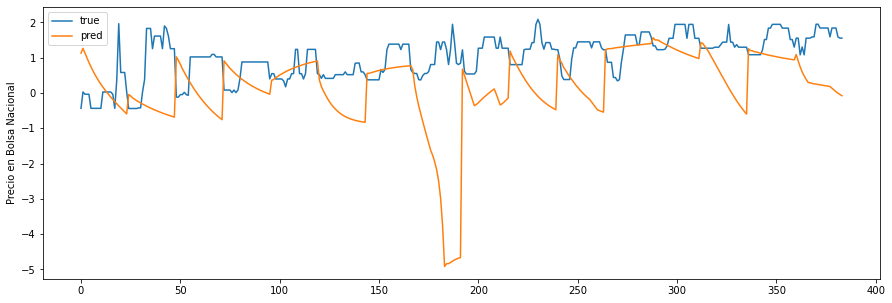

In [22]:
predictions = generate_predictions_style_1(inputs,labels,custom_rnn)
plot_comparison(labels,predictions)

In [23]:
performance['RNN'] = find_metrics_test(labels,predictions)

**Estilo 2:** Usando el último valor conocido.

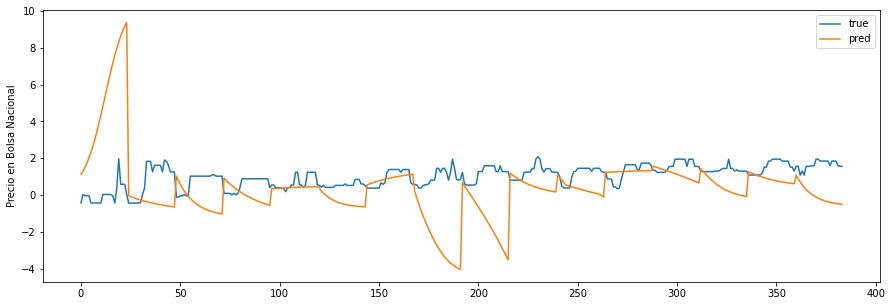

In [24]:
predictions = generate_predictions_style_2(inputs,labels,custom_rnn)
plot_comparison(labels,predictions)

### Long Short Term Memory

In [25]:
inputs = tf.keras.layers.Input(shape=(24,len(inputs_columns)))
custom_model = CustomModels.CustomLSTM(lstm_units=83,output_units=len(output_columns))
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_lstm_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 83)                33200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 84        
Total params: 33,284
Trainable params: 33,284
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = compile_and_fit(model=custom_lstm, window_train=train_generator,
                          window_val=val_generator,epochs=100,
                          steps_per_epoch=300,val_steps=300,patience=5)

Epoch 1/100
300/300 [==============================] - 5s 16ms/step - loss: 0.1604 - mean_absolute_error: 0.1747 - mean_absolute_percentage_error: 176.6065 - symmetric_mean_absolute_percentage_error: 52.0305 - val_loss: 0.0860 - val_mean_absolute_error: 0.2070 - val_mean_absolute_percentage_error: 230.6025 - val_symmetric_mean_absolute_percentage_error: 53.9657
Epoch 2/100
300/300 [==============================] - 3s 9ms/step - loss: 0.0487 - mean_absolute_error: 0.1186 - mean_absolute_percentage_error: 136.6948 - symmetric_mean_absolute_percentage_error: 40.1692 - val_loss: 0.0746 - val_mean_absolute_error: 0.1900 - val_mean_absolute_percentage_error: 274.6308 - val_symmetric_mean_absolute_percentage_error: 50.6781
Epoch 3/100
300/300 [==============================] - 3s 9ms/step - loss: 0.0486 - mean_absolute_error: 0.1105 - mean_absolute_percentage_error: 127.4054 - symmetric_mean_absolute_percentage_error: 38.0196 - val_loss: 0.0723 - val_mean_absolute_error: 0.1877 - val_mean_ab

In [27]:
val_performance['LSTM'] = custom_lstm.evaluate(val_generator)

546/546 [==============================] - 2s 4ms/step - loss: 0.0526 - mean_absolute_error: 0.1461 - mean_absolute_percentage_error: 264.4638 - symmetric_mean_absolute_percentage_error: 40.4669


In [28]:
inputs, labels = next(iter(test_generator))

**Estilo 1:** Usando todos los valores de Test.

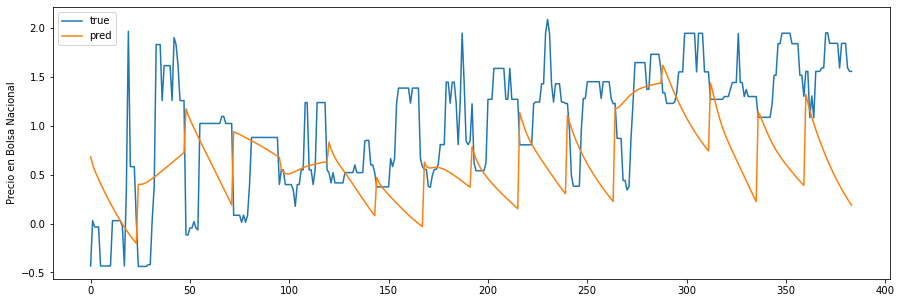

In [29]:
predictions = generate_predictions_style_1(inputs,labels,custom_lstm)
plot_comparison(labels,predictions)

In [30]:
performance['LSTM'] = find_metrics_test(labels,predictions)

**Estilo 2:** Usando el último valor conocido.

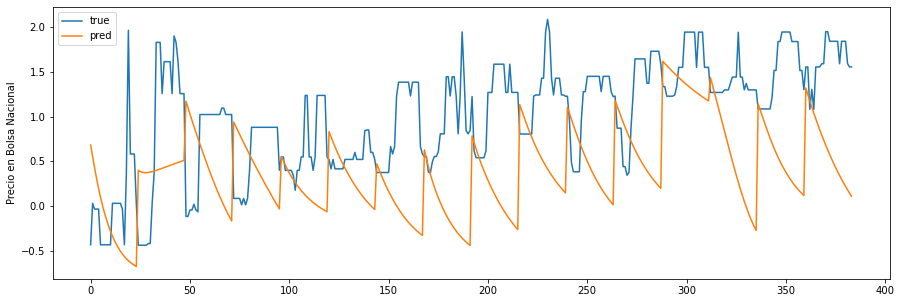

In [31]:
predictions = generate_predictions_style_2(inputs,labels,custom_lstm)
plot_comparison(labels,predictions)

### Gated Recurrent Unit

In [32]:
inputs = tf.keras.layers.Input(shape=(24,len(inputs_columns)))
custom_model = CustomModels.CustomGRU(gru_units=83,output_units=len(output_columns))
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_gru_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 83)                25149     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 84        
Total params: 25,233
Trainable params: 25,233
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = compile_and_fit(model=custom_gru, window_train=train_generator,
                          window_val=val_generator,epochs=100,
                          steps_per_epoch=300,val_steps=300,patience=5)

Epoch 1/100
300/300 [==============================] - 24s 79ms/step - loss: 0.1452 - mean_absolute_error: 0.1625 - mean_absolute_percentage_error: 199.8952 - symmetric_mean_absolute_percentage_error: 47.7325 - val_loss: 0.0592 - val_mean_absolute_error: 0.1573 - val_mean_absolute_percentage_error: 355.4486 - val_symmetric_mean_absolute_percentage_error: 43.3584
Epoch 2/100
300/300 [==============================] - 21s 69ms/step - loss: 0.0392 - mean_absolute_error: 0.1055 - mean_absolute_percentage_error: 132.6616 - symmetric_mean_absolute_percentage_error: 36.0365 - val_loss: 0.0580 - val_mean_absolute_error: 0.1552 - val_mean_absolute_percentage_error: 244.1945 - val_symmetric_mean_absolute_percentage_error: 44.0185
Epoch 3/100
300/300 [==============================] - 21s 70ms/step - loss: 0.0346 - mean_absolute_error: 0.1003 - mean_absolute_percentage_error: 104.7989 - symmetric_mean_absolute_percentage_error: 35.0993 - val_loss: 0.0562 - val_mean_absolute_error: 0.1508 - val_me

In [34]:
val_performance['GRU'] = custom_gru.evaluate(val_generator)

546/546 [==============================] - 3s 6ms/step - loss: 0.0492 - mean_absolute_error: 0.1319 - mean_absolute_percentage_error: 152.0523 - symmetric_mean_absolute_percentage_error: 36.3876


In [35]:
inputs, labels = next(iter(test_generator))

**Estilo 1:** Usando todos los valores de Test.

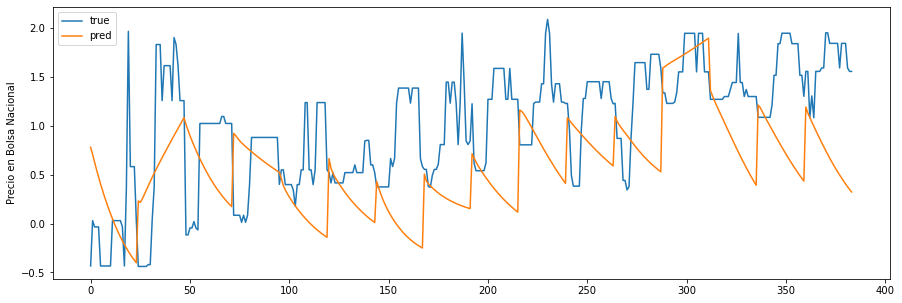

In [36]:
predictions = generate_predictions_style_1(inputs,labels,custom_gru)
plot_comparison(labels,predictions)

In [37]:
performance['GRU'] = find_metrics_test(labels,predictions)

**Estilo 2:** Usando el último valor conocido.

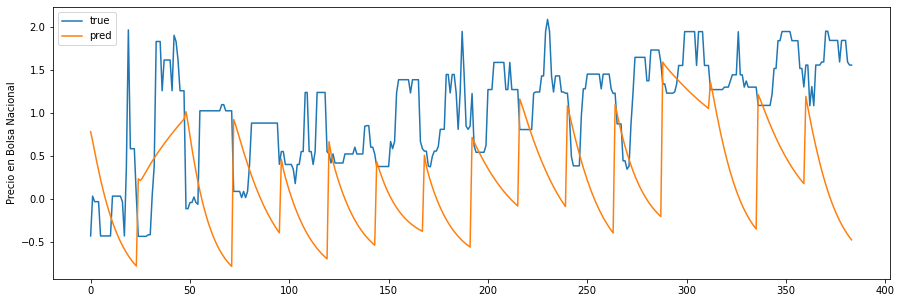

In [38]:
predictions = generate_predictions_style_2(inputs,labels,custom_gru)
plot_comparison(labels,predictions)

### Convolutional Neuronal Network

In [39]:
inputs = tf.keras.layers.Input(shape=(24,len(inputs_columns)))
custom_model = CustomModels.CustomCNN(dropout_rate=83,output_units=len(output_columns))
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 23, 64)            2112      
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 64)            256       
_________________________________________________________________
activation (Activation)      (None, 23, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 64)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [40]:
history = compile_and_fit(model=custom_cnn, window_train=train_generator,
                          window_val=val_generator,epochs=100,
                          steps_per_epoch=300,val_steps=300,patience=5)

Epoch 1/100
300/300 [==============================] - 4s 14ms/step - loss: 0.5845 - mean_absolute_error: 0.5413 - mean_absolute_percentage_error: 808.0327 - symmetric_mean_absolute_percentage_error: 109.1053 - val_loss: 0.2079 - val_mean_absolute_error: 0.3603 - val_mean_absolute_percentage_error: 743.8272 - val_symmetric_mean_absolute_percentage_error: 80.7940
Epoch 2/100
300/300 [==============================] - 2s 8ms/step - loss: 0.3301 - mean_absolute_error: 0.4132 - mean_absolute_percentage_error: 340.9946 - symmetric_mean_absolute_percentage_error: 96.5723 - val_loss: 0.1570 - val_mean_absolute_error: 0.3089 - val_mean_absolute_percentage_error: 824.0820 - val_symmetric_mean_absolute_percentage_error: 74.1740
Epoch 3/100
295/300 [============================>.] - ETA: 0s - loss: 0.3136 - mean_absolute_error: 0.3835 - mean_absolute_percentage_error: 394.2815 - symmetric_mean_absolute_percentage_error: 94.4078
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001000000

300/300 [==============================] - 2s 7ms/step - loss: 0.1971 - mean_absolute_error: 0.3019 - mean_absolute_percentage_error: 314.5995 - symmetric_mean_absolute_percentage_error: 81.6062 - val_loss: 0.1297 - val_mean_absolute_error: 0.2695 - val_mean_absolute_percentage_error: 546.5365 - val_symmetric_mean_absolute_percentage_error: 66.3095
Epoch 22/100
300/300 [==============================] - 2s 8ms/step - loss: 0.1991 - mean_absolute_error: 0.2931 - mean_absolute_percentage_error: 295.1862 - symmetric_mean_absolute_percentage_error: 78.7410 - val_loss: 0.1301 - val_mean_absolute_error: 0.2713 - val_mean_absolute_percentage_error: 533.2905 - val_symmetric_mean_absolute_percentage_error: 67.2601


In [41]:
val_performance['CNN'] = custom_cnn.evaluate(val_generator)

546/546 [==============================] - 2s 3ms/step - loss: 0.1272 - mean_absolute_error: 0.2684 - mean_absolute_percentage_error: 464.3884 - symmetric_mean_absolute_percentage_error: 67.0435


In [42]:
inputs, labels = next(iter(test_generator))

**Estilo 1:** Usando todos los valores de Test.

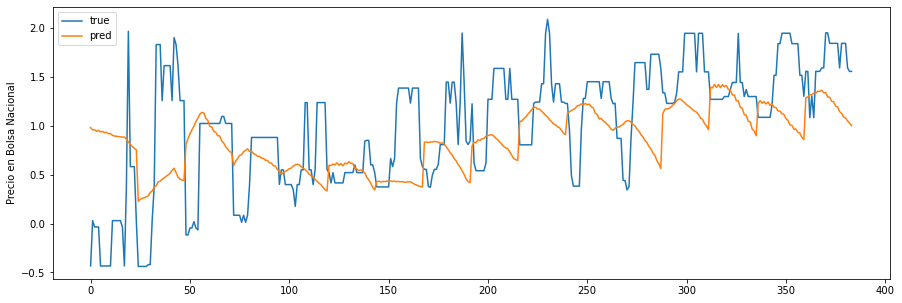

In [43]:
predictions = generate_predictions_style_1(inputs,labels,custom_cnn)
plot_comparison(labels,predictions)

In [44]:
performance['CNN'] = find_metrics_test(labels,predictions)

**Estilo 2:** Usando el último valor conocido.

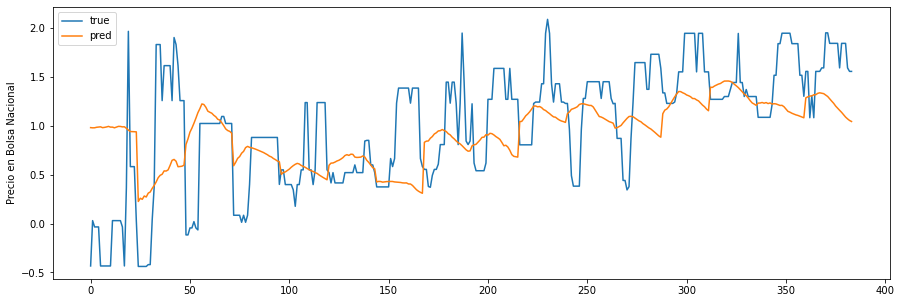

In [45]:
predictions = generate_predictions_style_2(inputs,labels,custom_cnn)
plot_comparison(labels,predictions)

## Metrics Summary

In [46]:
pd.DataFrame(val_performance,index=['Loss','Mean Absolute Error',
                                    'Mean Absolute Percentage Error',
                                    'Symetric Mean Absolute Percentage Error']).T

,Loss,Mean Absolute Error,Mean Absolute Percentage Error,Symetric Mean Absolute Percentage Error
DNN,0.054499,0.135877,181.651031,36.757420
LSTM,0.052604,0.146093,264.463806,40.466885
GRU,0.049206,0.131942,152.052322,36.387585
CNN,0.127203,0.268397,464.388428,67.043495


In [47]:
pd.DataFrame(performance,index=['Mean Absolute Error',
                                'Mean Absolute Percentage Error',
                                'Symetric Mean Absolute Percentage Error']).T

,Mean Absolute Error,Mean Absolute Percentage Error,Symetric Mean Absolute Percentage Error
RNN,1.034735,205.490982,2929.664993
LSTM,0.615979,169.923203,1946.680260
GRU,0.633322,166.963043,2180.796432
CNN,0.475005,207.526230,1395.334911
